In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, LSTM,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D,SimpleRNN


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link="https://drive.google.com/file/d/13DL3H3ShHMOuQo28TaxMsIiY59M8xMI8/view?usp=share_link"
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Emotion_final.csv')
df = pd.read_csv('Emotion_final.csv')

In [ ]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [ ]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [ ]:
category = pd.get_dummies(df.Emotion)
df1 = pd.concat([df, category], axis=1)
df1 = df1.drop(columns='Emotion')

Data Preprocessing

In [ ]:
X = df1['Text'].values
y = df1[['happy', 'sadness', 'anger', 'fear', 'love', 'surprise']].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
tokenizer = Tokenizer(num_words = 5000, oov_token='<x>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

Seq_train = tokenizer.texts_to_sequences(X_train)
Seq_test = tokenizer.texts_to_sequences(X_test)

Pad_train = pad_sequences(Seq_train)
Pad_test = pad_sequences(Seq_test)

In [ ]:
vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")


Vocabulary size = 19260


**LSTM**

Model Building

In [ ]:
model = Sequential([
    Embedding(input_dim = 5000, output_dim = 128),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)              

Model Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    Pad_train, y_train,
    epochs = 60,
    batch_size = 256,
    validation_data = (Pad_test, y_test),
    verbose = 1,
)

Epoch 1/60
68/68 [==============================] - 58s 779ms/step - loss: 1.6251 - accuracy: 0.3088 - val_loss: 1.5490 - val_accuracy: 0.3497
Epoch 2/60
68/68 [==============================] - 52s 763ms/step - loss: 1.2335 - accuracy: 0.5029 - val_loss: 0.8154 - val_accuracy: 0.6966
Epoch 3/60
68/68 [==============================] - 52s 762ms/step - loss: 0.5690 - accuracy: 0.7998 - val_loss: 0.5073 - val_accuracy: 0.8288
Epoch 4/60
68/68 [==============================] - 53s 781ms/step - loss: 0.3474 - accuracy: 0.8877 - val_loss: 0.4238 - val_accuracy: 0.8625
Epoch 5/60
68/68 [==============================] - 52s 760ms/step - loss: 0.2433 - accuracy: 0.9242 - val_loss: 0.3862 - val_accuracy: 0.8753
Epoch 6/60
68/68 [==============================] - 53s 786ms/step - loss: 0.1897 - accuracy: 0.9423 - val_loss: 0.3633 - val_accuracy: 0.8891
Epoch 7/60
68/68 [==============================] - 53s 786ms/step - loss: 0.1466 - accuracy: 0.9557 - val_loss: 0.3783 - val_accuracy: 0.8952

Graph Plot

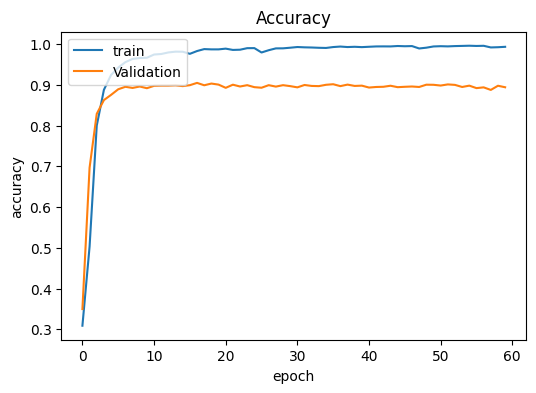

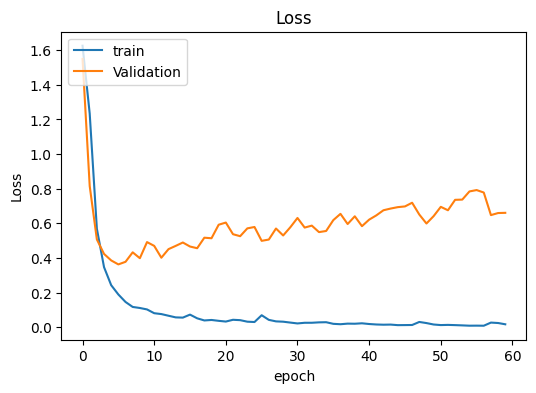

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()